Below the date correponding to each attack, in order to select a particular .csv (avoid loading **HUGE** file)
```
Benign ['01/03/2018' '16/02/2018' '02/03/2018' '23/02/2018' '15/02/2018'
 '28/02/2018' '22/02/2018' '10/01/1970' '11/01/1970' '12/01/1970'
 '21/02/2018' '14/02/2018' '05/01/1970' '08/01/1970' '20/02/2018']
DDOS attack-HOIC ['21/02/2018']
DDoS attacks-LOIC-HTTP ['20/02/2018']
DoS attacks-Hulk ['16/02/2018']
Bot ['02/03/2018']
FTP-BruteForce ['14/02/2018']
SSH-Bruteforce ['14/02/2018']
Infilteration ['01/03/2018' '28/02/2018']
DoS attacks-SlowHTTPTest ['16/02/2018']
DoS attacks-GoldenEye ['15/02/2018']
DoS attacks-Slowloris ['15/02/2018']
DDOS attack-LOIC-UDP ['21/02/2018']
Brute Force -Web ['23/02/2018' '22/02/2018']
Brute Force -XSS ['23/02/2018' '22/02/2018']
SQL Injection ['23/02/2018' '22/02/2018']
```


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import joblib
import sklearn
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, plot_confusion_matrix
from sklearn.utils import class_weight
import glob

RANDOM_STATE_SEED = 12

In [2]:
# read the whole dataset
all_files  = glob.glob("dataset/*14-02-2018*.csv")
print(all_files)

df = pd.concat((pd.read_csv(f) for f in all_files), ignore_index=True)

# display data
df

['dataset/Wednesday-14-02-2018_TrafficForML_CICFlowMeter.csv']


,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,0,0,14/02/2018 08:31:01,112641719,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320859.5,139.300036,56320958,56320761,Benign
1,0,0,14/02/2018 08:33:50,112641466,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56320733.0,114.551299,56320814,56320652,Benign
2,0,0,14/02/2018 08:36:39,112638623,3,0,0,0,0,0,...,0,0.0,0.0,0,0,56319311.5,301.934596,56319525,56319098,Benign
3,22,6,14/02/2018 08:40:13,6453966,15,10,1239,2273,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
4,22,6,14/02/2018 08:40:23,8804066,14,11,1143,2209,744,0,...,32,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,80,6,14/02/2018 10:53:23,10156986,5,5,1089,1923,587,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048571,80,6,14/02/2018 10:53:33,117,2,0,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048572,80,6,14/02/2018 10:53:28,5095331,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign
1048573,80,6,14/02/2018 10:53:28,5235511,3,1,0,0,0,0,...,20,0.0,0.0,0,0,0.0,0.000000,0,0,Benign


In [3]:
def cleanDataset(df):
    
    print('Initial size was ', df.shape)
    # replace +ve and -ve infinity with NaN
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # drop missing values
    print('Now drop missing values')
    df.dropna(inplace=True)
    
    print('Dataset cleaned. Now shape is', df.shape)
    
cleanDataset(df)

Initial size was  (1048575, 80)
Now drop missing values
Dataset cleaned. Now shape is (1044751, 80)


In [4]:
# feature information
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1044751 entries, 0 to 1048574
Data columns (total 80 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   Dst Port           1044751 non-null  int64  
 1   Protocol           1044751 non-null  int64  
 2   Timestamp          1044751 non-null  object 
 3   Flow Duration      1044751 non-null  int64  
 4   Tot Fwd Pkts       1044751 non-null  int64  
 5   Tot Bwd Pkts       1044751 non-null  int64  
 6   TotLen Fwd Pkts    1044751 non-null  int64  
 7   TotLen Bwd Pkts    1044751 non-null  int64  
 8   Fwd Pkt Len Max    1044751 non-null  int64  
 9   Fwd Pkt Len Min    1044751 non-null  int64  
 10  Fwd Pkt Len Mean   1044751 non-null  float64
 11  Fwd Pkt Len Std    1044751 non-null  float64
 12  Bwd Pkt Len Max    1044751 non-null  int64  
 13  Bwd Pkt Len Min    1044751 non-null  int64  
 14  Bwd Pkt Len Mean   1044751 non-null  float64
 15  Bwd Pkt Len Std    1044751 non-n

In [5]:
df.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Act Data Pkts,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min
count,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,...,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06,1.044751e+06
mean,4.711645e+03,8.115271e+00,6.278451e+06,6.222033e+00,7.237526e+00,4.495806e+02,4.538354e+03,1.751610e+02,8.418147e+00,3.891090e+01,...,2.803716e+00,2.329159e+01,5.171308e+04,2.143970e+04,8.821327e+04,4.010102e+04,3.112557e+06,7.323927e+05,4.830005e+06,2.134705e+06
std,1.420505e+04,4.466955e+00,1.262595e+09,4.455911e+01,1.050590e+02,1.576416e+04,1.517789e+05,2.880300e+02,1.951045e+01,5.337757e+01,...,5.564710e+00,1.108023e+01,5.826136e+05,2.190364e+05,7.409056e+05,5.612885e+05,5.424680e+08,3.827015e+08,1.524900e+09,1.820290e+07
min,0.000000e+00,0.000000e+00,-9.190110e+11,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.200000e+01,6.000000e+00,7.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,5.300000e+01,6.000000e+00,1.040000e+03,2.000000e+00,1.000000e+00,3.600000e+01,5.600000e+01,3.500000e+01,0.000000e+00,2.566667e+01,...,0.000000e+00,2.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,4.430000e+02,6.000000e+00,4.087895e+05,8.000000e+00,6.000000e+00,4.550000e+02,7.880000e+02,2.010000e+02,0.000000e+00,5.600000e+01,...,4.000000e+00,3.200000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,6.553300e+04,1.700000e+01,1.200000e+08,5.115000e+03,9.198000e+03,8.591554e+06,1.339773e+07,6.444000e+04,1.460000e+03,1.121703e+04,...,1.031000e+03,4.800000e+01,1.102401e+08,5.723446e+07,1.102401e+08,1.102401e+08,3.394503e+11,2.432682e+11,9.797810e+11,1.260300e+10


In [6]:
df["Label"].value_counts()

Benign            663808
FTP-BruteForce    193354
SSH-Bruteforce    187589
Name: Label, dtype: int64

Since our goal is binary classification ("attack" vs "not attack"), we can group all attacks under one name, 'Attack'



In [7]:
df.replace(to_replace=["FTP-BruteForce", "SSH-Bruteforce"], value="Malware", inplace=True)


<AxesSubplot:title={'center':'Event Label'}>

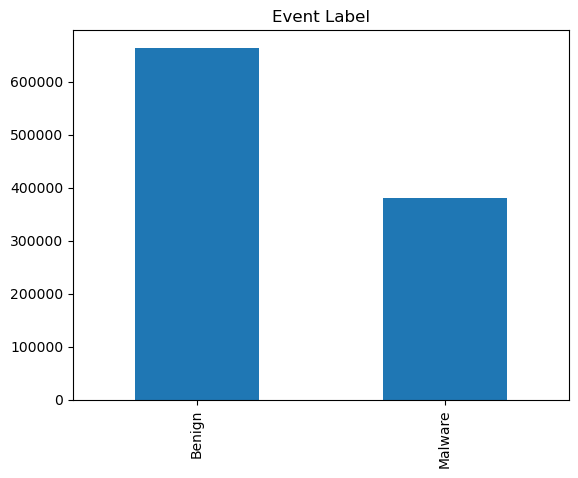

In [8]:
df["Label"].value_counts().plot(kind='bar',
                               y='Events',
                               title='Event Label'
                               )

In [9]:
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
import plotly.express as px
init_notebook_mode(connected=True)
import plotly.graph_objs as go

fig = go.Figure(data=[
    go.Bar(name='Benign', 
           y=df["Label"].value_counts().values[0:1],
           x=['Benign'],
           text = df["Label"].value_counts()[0:1],
           orientation='v',
           textposition='outside',),
    go.Bar(name='Malware', 
           y=df["Label"].value_counts().values[1:2],
           x=['Malware'],
           text = df["Label"].value_counts()[1:2],
           orientation='v',
           textposition='outside',)
])
# Change the bar mode
fig.update_layout(
                  width=800,
                  height=600,
                  title=f'Class Distribution',
                  yaxis_title='Number of attacks',
                  xaxis_title='Attack Name',)
iplot(fig)

In [10]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

In [11]:
#some plots
def comparePlots(variable, df, n_bins = 25):
    x1 = df[df['Label'] == 'Benign'][variable]
    x2 = df[df['Label'] == 'Malware'][variable]

    print(x1.mean())
    print(x2.describe())
    fig, axs = plt.subplots(1, 1, tight_layout=True)

    # We can set the number of bins with the *bins* keyword argument.
    
    #axs.hist(x2, bins=n_bins, color='red')
    #axs.hist(x1, bins=n_bins)
    
#comparePlots('', df)
 
def featureInfo(df):
    for col in df.columns:
        if 'Label' in col or 'Timestamp' in col: continue
        x1 = df[df['Label'] == 'Benign'][col]
        x2 = df[df['Label'] == 'Malware'][col]
        print(col, x1.mean(), x2.mean())
        
        

In [12]:
featureInfo(df)

Dst Port 7403.207773934631 21.492354499229542
Protocol 9.329173495950636 6.0
Flow Duration 9829684.268521922 90289.41069398833
Tot Fwd Pkts 6.18837525308523 6.28068241180439
Tot Bwd Pkts 7.947816236020054 5.999818870539687
TotLen Fwd Pkts 434.2225673688778 476.3426339373607
TotLen Bwd Pkts 6766.160490684053 656.3140679839241
Fwd Pkt Len Max 185.22835819996143 157.61812134623815
Fwd Pkt Len Min 13.249114201696877 0.0
Fwd Pkt Len Mean 49.0322977959358 21.27395897726517
Fwd Pkt Len Std 59.89971582136596 33.737272078808026
Bwd Pkt Len Max 387.32563632857693 240.36763505301317
Bwd Pkt Len Min 31.854305763112226 0.0
Bwd Pkt Len Mean 128.80998721055295 30.87160938227342
Bwd Pkt Len Std 138.90105254510124 64.56882702716172
Flow Byts/s 303232.3586892505 3118.943707129405
Flow Pkts/s 30975.586067438897 681639.4107389452
Flow IAT Mean 2500845.9093440906 2117.8660623214
Flow IAT Std 3316674.8847330417 5096.990962885704
Flow IAT Max 9946793.391308933 25191.90799148429
Flow IAT Min -2400279.86879790

## DNN approach

To prevent our classification model from being biased, we should make sure that the class distribution is even (i.e. 50% benign and 50% malware).

In [13]:
nSize = df[df["Label"] == "Malware"].shape[0]
print(nSize)
df1 = df[df["Label"] == "Benign"][:nSize]
df2 = df[df["Label"] == "Malware"][:nSize]
df_equal = pd.concat([ df1,df2], axis =0)

#We now encode our class labels to integer values for the model to use.

df_equal.replace(to_replace="Benign", value=0, inplace=True)
df_equal.replace(to_replace="Malware", value=1, inplace=True)

380943


In [14]:
train, test = train_test_split(df_equal, test_size=0.3, random_state=RANDOM_STATE_SEED)

All of our data except the 'Timestamp' column is numerical. These numerical columns contain different ranges of values, which can confuse our model. Thus, we must normalize our data.

In [15]:
min_max_scaler = MinMaxScaler().fit(train[['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']])

numerical_columns = ['Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
       'Fwd Seg Size Avg', 'Bwd Seg Size Avg', 'Fwd Byts/b Avg',
       'Fwd Pkts/b Avg', 'Fwd Blk Rate Avg', 'Bwd Byts/b Avg',
       'Bwd Pkts/b Avg', 'Bwd Blk Rate Avg', 'Subflow Fwd Pkts',
       'Subflow Fwd Byts', 'Subflow Bwd Pkts', 'Subflow Bwd Byts',
       'Init Fwd Win Byts', 'Init Bwd Win Byts', 'Fwd Act Data Pkts',
       'Fwd Seg Size Min', 'Active Mean', 'Active Std', 'Active Max',
       'Active Min', 'Idle Mean', 'Idle Std', 'Idle Max', 'Idle Min']

In [16]:
train[numerical_columns] = min_max_scaler.transform(train[numerical_columns])

In [17]:
train

,Dst Port,Protocol,Timestamp,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
677869,53,17,14/02/2018 04:13:13,0.999869,0.000000,0.000111,0.000005,0.000008,0.000667,0.036565,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
429458,53,17,14/02/2018 08:45:12,0.999869,0.000000,0.000111,0.000006,0.000012,0.000791,0.043367,...,0.166667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
636880,49965,6,14/02/2018 09:21:42,0.999869,0.000204,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
760015,51970,6,14/02/2018 01:57:08,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
362516,22,6,14/02/2018 03:19:01,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183725,22,6,14/02/2018 02:05:58,0.999870,0.004279,0.002433,0.000234,0.000202,0.009932,0.000000,...,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
32083,21,6,14/02/2018 10:49:29,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
637768,80,6,14/02/2018 10:49:13,0.999929,0.000204,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
380644,21,6,14/02/2018 12:10:06,0.999869,0.000000,0.000111,0.000000,0.000000,0.000000,0.000000,...,0.833333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [18]:
train.describe()

,Dst Port,Protocol,Flow Duration,Tot Fwd Pkts,Tot Bwd Pkts,TotLen Fwd Pkts,TotLen Bwd Pkts,Fwd Pkt Len Max,Fwd Pkt Len Min,Fwd Pkt Len Mean,...,Fwd Seg Size Min,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
count,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,5.333200e+05,533320.000000,533320.000000,533320.000000,533320.000000,...,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000,533320.000000
mean,3626.720260,7.611832,0.999873,0.001052,0.000750,5.893228e-05,0.000252,0.002818,0.005449,0.003284,...,0.543590,0.000579,0.000295,0.000854,0.000449,0.000008,0.000004,0.000005,0.000133,0.500051
std,12468.804317,4.000155,0.001753,0.006889,0.009476,2.564790e-03,0.009352,0.004789,0.014728,0.004958,...,0.233554,0.006671,0.003658,0.007835,0.006333,0.001786,0.001748,0.001729,0.001754,0.500000
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,21.000000,6.000000,0.999869,0.000000,0.000111,0.000000e+00,0.000000,0.000000,0.000000,0.000000,...,0.416667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,22.000000,6.000000,0.999869,0.000000,0.000111,1.163934e-07,0.000000,0.000016,0.000000,0.000045,...,0.666667,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
75%,137.000000,6.000000,0.999870,0.001426,0.000774,6.774095e-05,0.000120,0.005307,0.000000,0.005745,...,0.833333,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,65532.000000,17.000000,1.000000,1.000000,1.000000,1.000000e+00,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [19]:
train.drop(['Timestamp'], axis=1,inplace=True)
test.drop(['Timestamp'],axis=1,inplace=True)

In [20]:
test[numerical_columns] = min_max_scaler.transform(test[numerical_columns])


In [21]:
print("Full dataset:\n")
print("Benign: " + str(df_equal["Label"].value_counts()[[0]].sum()))
print("Malware: " + str(df_equal["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Training set:\n")
print("Benign: " + str(train["Label"].value_counts()[[0]].sum()))
print("Malware: " + str(train["Label"].value_counts()[[1]].sum()))
print("---------------")

print("Test set:\n")
print("Benign: " + str(test["Label"].value_counts()[[0]].sum()))
print("Malware: " + str(test["Label"].value_counts()[[1]].sum()))

Full dataset:

Benign: 380943
Malware: 380943
---------------
Training set:

Benign: 266633
Malware: 266687
---------------
Test set:

Benign: 114310
Malware: 114256


In [22]:
y_train = np.array(train.pop("Label"))# pop removes "Label" from the dataframe
#y_train = np.array(train.pop("Timestamp"))
X_train = train.values

print(type(X_train))
print(type(y_train))
print(X_train.shape)
print(y_train.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(533320, 78)
(533320,)


In [23]:
y_test = np.array(test.pop("Label")) # pop removes "Label" from the dataframe
#y_test = np.array(test.pop("Timestamp"))
X_test = test.values

print(type(X_test))
print(type(y_test))
print(X_test.shape)
print(y_test.shape)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
(228566, 78)
(228566,)


## NN with Keras

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

2022-10-28 02:34:57.635557: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 02:34:57.830454: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-28 02:34:58.392517: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-10-28 02:34:58.392591: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

In [25]:
neuralNetModel = keras.Sequential([
    layers.InputLayer(input_shape=(78,)),
       
    layers.BatchNormalization(renorm=True),
    layers.Dense(128, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(renorm=True),
    layers.Dense(64, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.BatchNormalization(renorm=True),
    layers.Dense(32, activation='relu'),
    layers.Dropout(rate = 0.3),
    layers.Dense(1, activation='sigmoid'),
])

neuralNetModel.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 78)               546       
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 128)               10112     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 batch_normalization_1 (Batc  (None, 128)              896       
 hNormalization)                                                 
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

2022-10-28 02:34:59.992795: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-28 02:35:00.828323: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 30975 MB memory:  -> device: 0, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:21:00.0, compute capability: 7.0
2022-10-28 02:35:00.829086: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1616] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 30975 MB memory:  -> device: 1, name: Tesla V100S-PCIE-32GB, pci bus id: 0000:81:00.0, compute capability: 7.0


In [26]:
optimizer = tf.keras.optimizers.Adam(epsilon=0.01)

from tensorflow.keras import callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta = 0.001,
    patience = 5,
    restore_best_weights = True
)

neuralNetModel.compile(
    optimizer=optimizer,
    loss='binary_crossentropy',
    metrics=['binary_accuracy'],
)

history = neuralNetModel.fit(
    X_train, y_train,
    epochs=50,
    batch_size = 256,
    validation_split=0.25,
    callbacks=[early_stopping]
)

Epoch 1/50
1563/1563 [==============================] - 8s 4ms/step - loss: 0.1820 - binary_accuracy: 0.9648 - val_loss: 0.0017 - val_binary_accuracy: 0.9997
Epoch 2/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0041 - binary_accuracy: 0.9995 - val_loss: 8.8192e-04 - val_binary_accuracy: 0.9998
Epoch 3/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0022 - binary_accuracy: 0.9997 - val_loss: 5.0384e-04 - val_binary_accuracy: 0.9998
Epoch 4/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0014 - binary_accuracy: 0.9998 - val_loss: 2.8905e-04 - val_binary_accuracy: 0.9998
Epoch 5/50
1563/1563 [==============================] - 6s 4ms/step - loss: 0.0011 - binary_accuracy: 0.9998 - val_loss: 4.2758e-05 - val_binary_accuracy: 1.0000
Epoch 6/50
1563/1563 [==============================] - 6s 4ms/step - loss: 8.7107e-04 - binary_accuracy: 0.9999 - val_loss: 3.7940e-05 - val_binary_accuracy: 1.0000
Epoch 7/50
1563/1563 [======

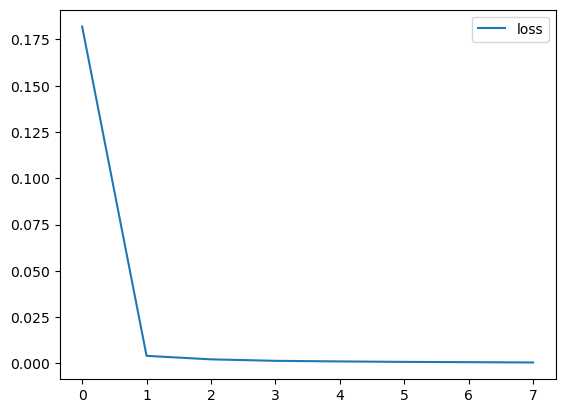

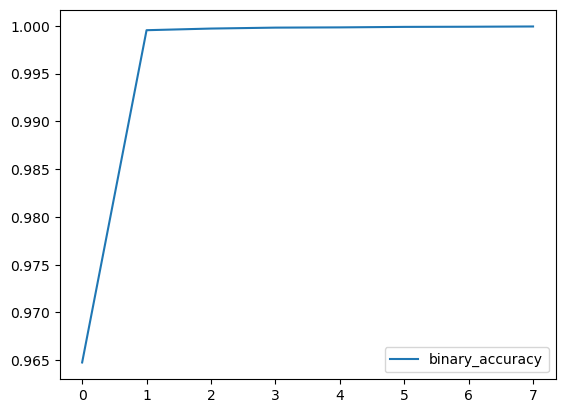

In [27]:
history_frame = pd.DataFrame(history.history)
history_frame.loc[:, ['loss']].plot()
history_frame.loc[:, ['binary_accuracy']].plot();

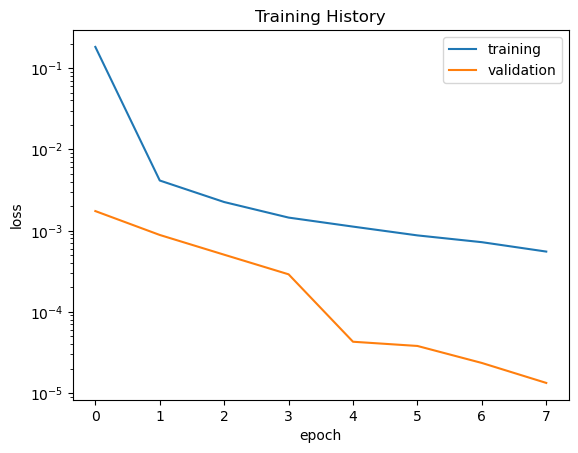

In [29]:
# plot training history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.yscale('log')
plt.title('Training History')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='upper right')
plt.show()

In [30]:
scores = neuralNetModel.evaluate(X_test, y_test )
print("\n%s: %.2f%%" % (neuralNetModel.metrics_names[1], scores[1]*100))

7143/7143 [==============================] - 10s 1ms/step - loss: 5.5533e-04 - binary_accuracy: 0.9998

binary_accuracy: 99.98%


In [46]:
predictions=(neuralNetModel.predict(X_test) > 0.5).astype("int32")

7143/7143 [==============================] - 6s 860us/step


In [47]:
print(accuracy_score(y_test, predictions))

0.9998468713631948


<AxesSubplot:>

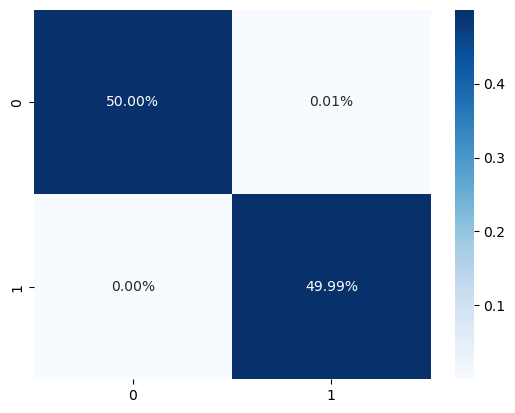

In [48]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, predictions)
import seaborn as sns
#sns.heatmap(cf_matrix, annot=True)
sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, 
            fmt='.2%', cmap='Blues')

In [44]:
for i in range(5):
    print( '%d (expected %d)' % ( predictions[i], y_test[i]))

1 (expected 1)
1 (expected 1)
0 (expected 0)
1 (expected 1)
0 (expected 0)
